In [3]:
import paramiko
import time
import pandas as pd
from io import StringIO

username = input("user? ")
password = input("password? ") 
host_cms1 = "cms1.physics.ucsb.edu"
host_cms2 = "cms2"
remote_file = "/cms2r0/kiekover/plots/LukasRuns.txt"

# SSH to cms1
ssh = paramiko.SSHClient()
ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())
ssh.connect(host_cms1, username=username, password=password)

# Start an interactive shell on cms1
channel = ssh.invoke_shell()
time.sleep(1)
channel.recv(9999)  # clear login banner

# SSH into cms2
channel.send(f"ssh {host_cms2}\n")
time.sleep(1)
output = channel.recv(9999).decode("utf-8")
if "password" in output.lower():
    channel.send(password + "\n")
    time.sleep(1)
    channel.recv(9999)  # clear login text

# Run 'cat' to get the whole file
channel.send(f"cat {remote_file}\n")
time.sleep(2)  # wait for command to finish

# Receive all data available
output = channel.recv(999999).decode("utf-8")

ssh.close()

username,password = _,_

# Filter lines with exactly 9 columns
lines = []
for line in output.strip().split("\n"):
    cols = line.strip().split()
    if len(cols) == 9:
        lines.append(line)

# Load into DataFrame
data_str = "\n".join(lines)
df_base = pd.read_csv(StringIO(data_str), sep=r"\s+", header=0)

print(df_base.head())  # Show first few rows

     Run   x   y  HVSlab  HVBar  MPV3  dMPV3  MPV4  dMPV3.1
0  65837  28   5     760    760   5.5    0.5  26.5      0.5
1  65838  28  36     760    760   0.0    0.0   0.0      0.0
2  65839  28  36     760    760   0.0    0.0   0.0      0.0
3  65840  28  65     760    760  22.0    1.0   5.5      0.5
4  65841  42   5     760    760   0.0    0.0   0.0      0.0


In [31]:
not_empty = df_base.columns[-4:]
df = df_base[~(df_base[not_empty] == 0).all(axis=1)]  

# Channel 3 Analysis

In [80]:
df_ch3 = df

In [81]:
import numpy as np

#Multiple HV positions
multi = df_ch3.groupby(["x", "y"]).filter(lambda g: g["HVSlab"].nunique() > 1)
log_HV = np.log(multi["HVSlab"].values)
log_MPV = np.log(multi["MPV3"].values)

pos_idx = {p: i for i, p in enumerate(set(zip(multi["x"], multi["y"])))}
X = np.zeros((len(log_HV), len(pos_idx) + 1))
for i, p in enumerate(zip(multi["x"], multi["y"])):
    X[i, pos_idx[p]] = 1
X[:, -1] = log_HV

beta, *_ = np.linalg.lstsq(X, log_MPV, rcond=None)
a_vals = np.exp(beta[:-1])
b_global = beta[-1]

params = {p: a for p, a in zip(pos_idx.keys(), a_vals)}

#Single HV positions
single = df_ch3.groupby(["x", "y"]).filter(lambda g: g["HVSlab"].nunique() == 1)
for (x, y), g in single.groupby(["x", "y"]):
    hv_val = g["HVSlab"].iloc[0]
    mpv_val = g["MPV3"].iloc[0]
    params[(x, y)] = mpv_val / (hv_val ** b_global)

#output it as a dataframe with rows [(x,y),a,b]. Now to call the row you ask for param_df.loc[(x,y)]
df_ch3_fit = pd.DataFrame([(x, y, a, b_global) for (x, y), a in params.items()],columns=["x" , "y", "a", "b"])

#evaluate it out to 1450 and add it as a column
df_ch3_fit["MPV3_at_1450"] = df_ch3_fit["a"] * (1450 ** df_ch3_fit["b"])  

In [82]:
#extract x,y, and MPV3_at1450
xs = df_ch3_fit["x"].values
ys = df_ch3_fit["y"].values
MPV3_at_1450 = df_ch3_fit["MPV3_at_1450"].values

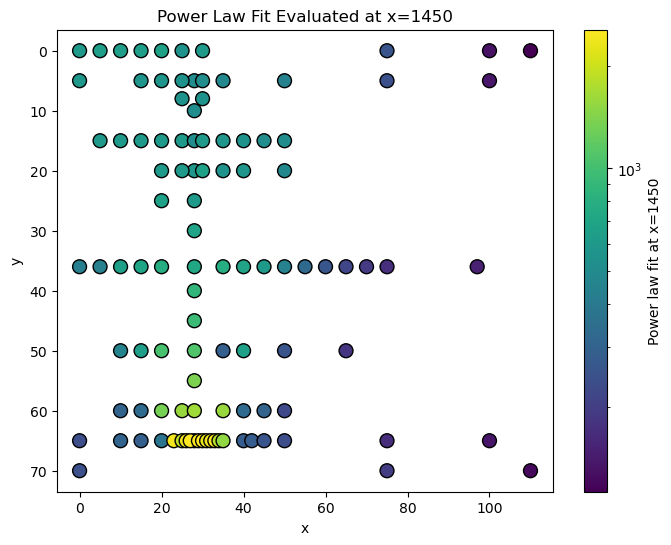

In [83]:
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

plt.figure(figsize=(8,6))
xyhist = plt.scatter(xs, ys, c=MPV3_at_1450, cmap='viridis', s=100, edgecolor='k',norm=LogNorm())
plt.colorbar(xyhist, label='Power law fit at x=1450')
plt.gca().invert_yaxis()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Power Law Fit Evaluated at x=1450')
plt.show()

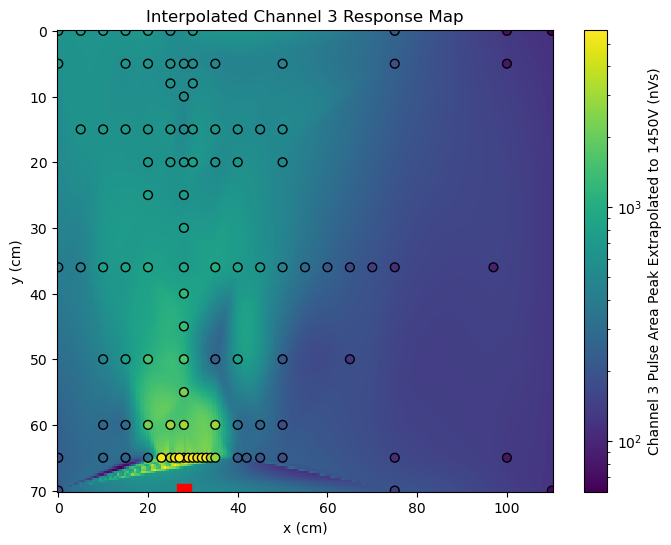

In [84]:
from scipy.interpolate import griddata
from matplotlib.colors import LogNorm

log_z = np.log10(MPV3_at_1450)
xgrid = np.linspace(xs.min(), xs.max(), 200)
ygrid = np.linspace(ys.min(), ys.max(), 200)
Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)
Zgrid_log = griddata(points=(xs, ys), values=log_z, xi=(Xgrid, Ygrid), method='cubic') #I wound up in this really round about way of doing it and now I'm scared to change it
Zgrid = 10 ** Zgrid_log

plt.figure(figsize=(8,6))
plt.pcolormesh(Xgrid, Ygrid, Zgrid, shading='auto', cmap='viridis', norm=LogNorm())
plt.colorbar(label='Channel 3 Pulse Area Peak Extrapolated to 1450V (nVs)')
plt.scatter(xs, ys, c=MPV3_at_1450, cmap='viridis', norm=LogNorm(), edgecolor='k', s=40)
plt.scatter(28,70,color = 'red',marker = 's',s=100)
plt.gca().invert_yaxis()
plt.xlabel('x (cm)')
plt.ylabel('y (cm)')
plt.title('Interpolated Channel 3 Response Map')
plt.show()

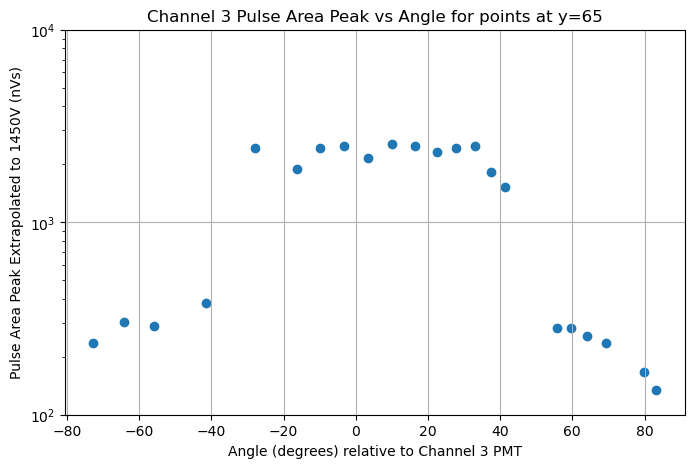

In [85]:
#take only the points at y = 65
mask = (ys == 65)
xs_65 = xs[mask]
ys_65 = ys[mask]
MPV3_at_1450_65 = MPV3_at_1450[mask]

angles = np.arctan(((xs_65+2.5)-30)/(76-(65+2.5)))*180/np.pi

plt.figure(figsize=(8,5))
plt.scatter(angles, MPV3_at_1450_65)
plt.yscale('log')
plt.ylim(100,10e3)
plt.xlabel("Angle (degrees) relative to Channel 3 PMT")
plt.ylabel("Pulse Area Peak Extrapolated to 1450V (nVs)")
plt.title("Channel 3 Pulse Area Peak vs Angle for points at y=65")
plt.grid(True)
plt.show()

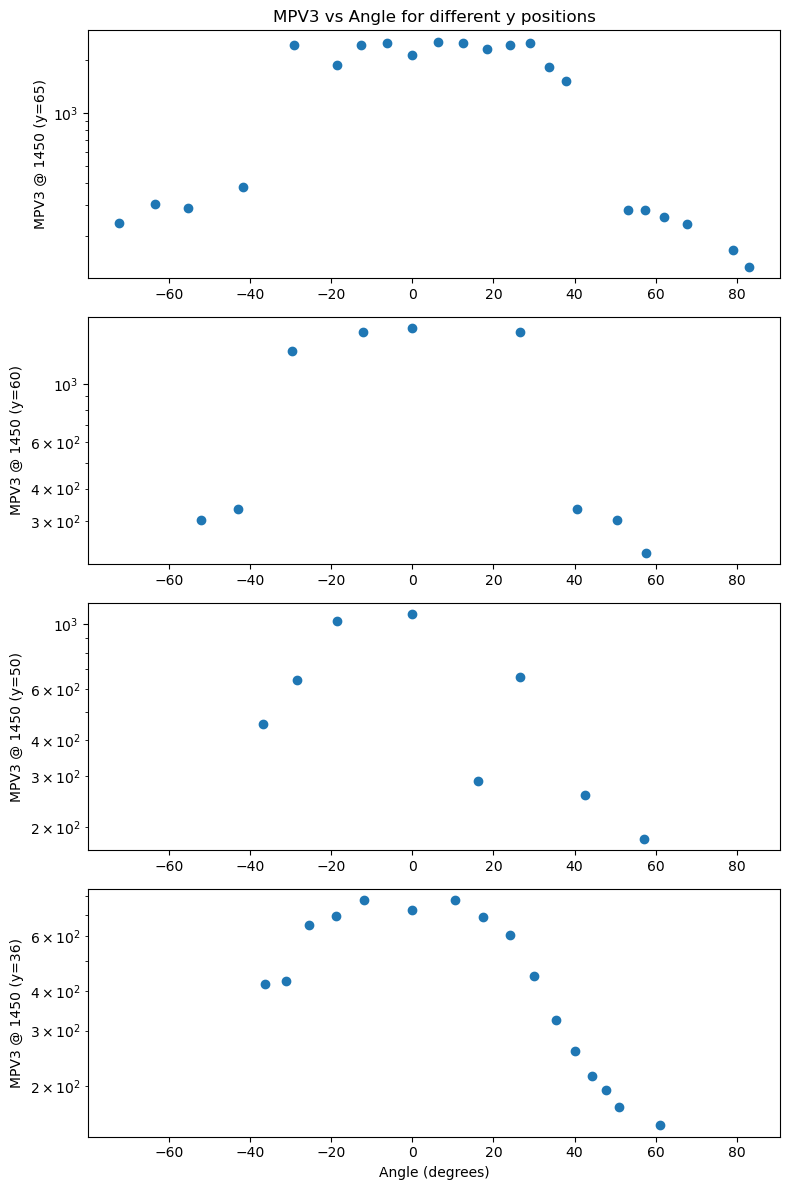

In [86]:
mask = (ys == 65)
xs_65 = xs[mask]
ys_65 = ys[mask]
MPV3_at_1450_65 = MPV3_at_1450[mask]

mask = (ys == 60)
xs_60 = xs[mask]
ys_60 = ys[mask]
MPV3_at_1450_60 = MPV3_at_1450[mask]

mask = (ys == 50)
xs_50 = xs[mask]
ys_50 = ys[mask]
MPV3_at_1450_50 = MPV3_at_1450[mask]

mask = (ys == 36)
xs_36 = xs[mask]
ys_36 = ys[mask]
MPV3_at_1450_36 = MPV3_at_1450[mask]


angles_65 = np.arctan((xs_65-28)/(9))*180/np.pi
angles_60 = np.arctan((xs_60-28)/(14))*180/np.pi
angles_50 = np.arctan((xs_50-28)/(24))*180/np.pi
angles_36 = np.arctan((xs_36-28)/(38))*180/np.pi

fig, axs = plt.subplots(4, 1, figsize=(8, 12), sharex=True)

# Plot each row
axs[0].scatter(angles_65, MPV3_at_1450_65)
axs[0].set_ylabel('MPV3 @ 1450 (y=65)')
axs[0].set_title('MPV3 vs Angle for different y positions')
axs[0].set_yscale('log')
axs[0].tick_params(axis='x', labelbottom=True) 

axs[1].scatter(angles_60, MPV3_at_1450_60)
axs[1].set_ylabel('MPV3 @ 1450 (y=60)')
axs[1].set_yscale('log')
axs[1].tick_params(axis='x', labelbottom=True)

axs[2].scatter(angles_50, MPV3_at_1450_50)
axs[2].set_ylabel('MPV3 @ 1450 (y=50)')
axs[2].set_yscale('log')
axs[2].tick_params(axis='x', labelbottom=True)

axs[3].scatter(angles_36, MPV3_at_1450_36)
axs[3].set_ylabel('MPV3 @ 1450 (y=36)')
axs[3].set_xlabel('Angle (degrees)')
axs[3].set_yscale('log')
axs[3].tick_params(axis='x', labelbottom=True)

# Optional: adjust spacing
plt.tight_layout()
plt.show()

In [87]:
print(len(angles_36))

16


# Channel 4 Analysis

In [88]:
df_ch4 = df[df["Run"] >= 65903] #anything below this number has a scaling difference between channels 3 and 4. channel 4 was scaled after this point, so if you want to use channel 3 data, that will line up as it should.

In [89]:

#Multiple HV positions
multi = df_ch4.groupby(["x", "y"]).filter(lambda g: g["HVSlab"].nunique() > 1)
log_HV = np.log(multi["HVSlab"].values)
log_MPV = np.log(multi["MPV4"].values)

pos_idx = {p: i for i, p in enumerate(set(zip(multi["x"], multi["y"])))}
X = np.zeros((len(log_HV), len(pos_idx) + 1))
for i, p in enumerate(zip(multi["x"], multi["y"])):
    X[i, pos_idx[p]] = 1
X[:, -1] = log_HV

beta, *_ = np.linalg.lstsq(X, log_MPV, rcond=None)
a_vals = np.exp(beta[:-1])
b_global = beta[-1]

params = {p: a for p, a in zip(pos_idx.keys(), a_vals)}

#Single HV positions
single = df_ch4.groupby(["x", "y"]).filter(lambda g: g["HVSlab"].nunique() == 1)
for (x, y), g in single.groupby(["x", "y"]):
    hv_val = g["HVSlab"].iloc[0]
    mpv_val = g["MPV4"].iloc[0]
    params[(x, y)] = mpv_val / (hv_val ** b_global)

df_ch4_fit = pd.DataFrame([(x, y, a, b_global) for (x, y), a in params.items()],columns=["x" , "y", "a", "b"])

#evaluate it out to 1450 and add it as a column
df_ch4_fit["MPV4_at_1450"] = df_ch4_fit["a"] * (1450 ** df_ch4_fit["b"])  

In [90]:
#extract x,y, and MPV3_at1450
xs = df_ch4_fit["x"].values
ys = df_ch4_fit["y"].values
MPV4_at_1450 = df_ch4_fit["MPV4_at_1450"].values

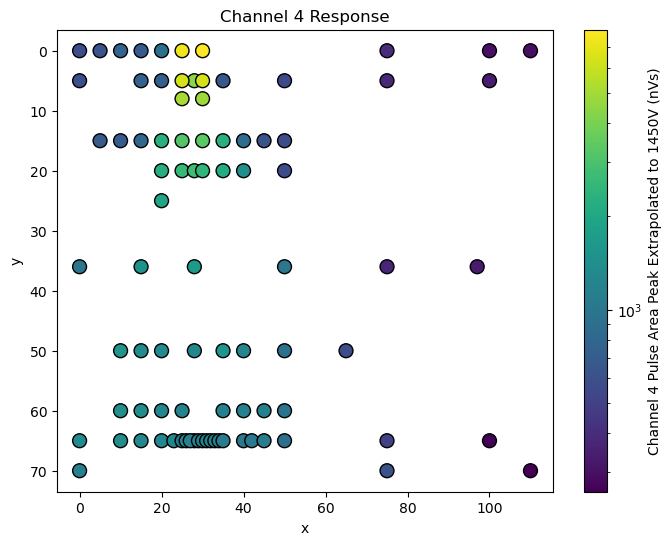

In [91]:
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

plt.figure(figsize=(8,6))
sc = plt.scatter(xs, ys, c=MPV4_at_1450, cmap='viridis', s=100,norm = LogNorm(), edgecolor='k')
plt.colorbar(sc, label='Channel 4 Pulse Area Peak Extrapolated to 1450V (nVs)')
plt.gca().invert_yaxis()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Channel 4 Response')
plt.show()

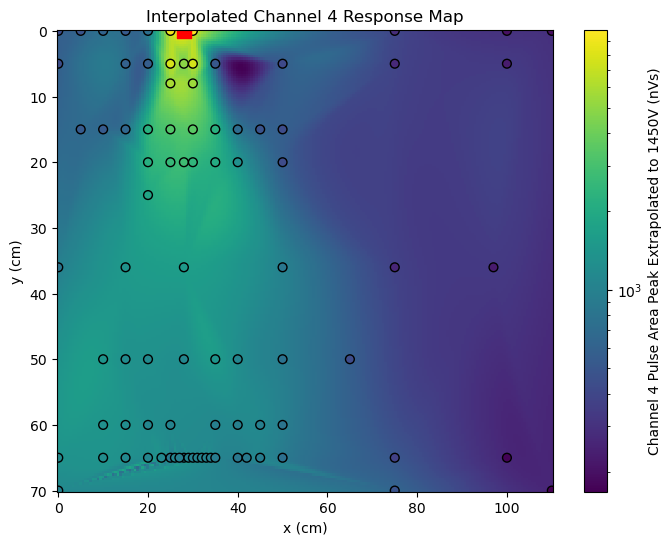

In [92]:
from scipy.interpolate import griddata

log_z = np.log10(MPV4_at_1450)
xgrid = np.linspace(xs.min(), xs.max(), 200)
ygrid = np.linspace(ys.min(), ys.max(), 200)
Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)
Zgrid_log = griddata(points=(xs, ys), values=log_z, xi=(Xgrid, Ygrid), method='cubic')
Zgrid = 10 ** Zgrid_log

plt.figure(figsize=(8,6))
plt.pcolormesh(Xgrid, Ygrid, Zgrid, shading='auto', cmap='viridis', norm=LogNorm())
plt.colorbar(label='Channel 4 Pulse Area Peak Extrapolated to 1450V (nVs)')
plt.scatter(xs, ys, c=MPV4_at_1450, cmap='viridis', norm=LogNorm(), edgecolor='k', s=40)
plt.scatter(28,0,color = 'red',marker = 's',s=100)
plt.gca().invert_yaxis()
plt.xlabel('x (cm)')
plt.ylabel('y (cm)')
plt.title('Interpolated Channel 4 Response Map')
plt.show()

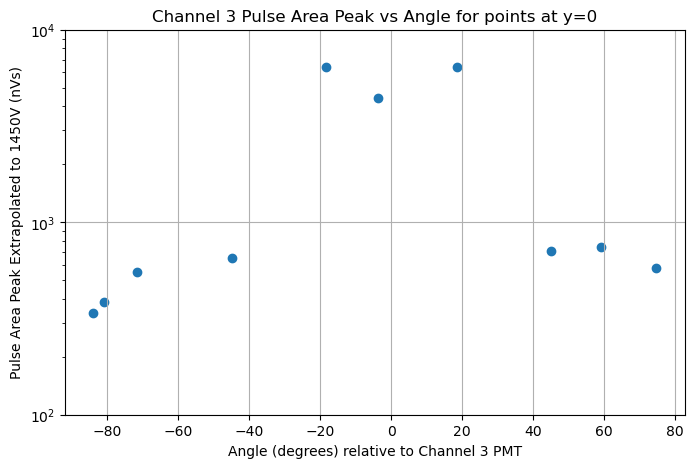

In [93]:
#take only the points at y = 5
mask = (ys == 5)
xs_5 = xs[mask]
ys_5 = ys[mask]
MPV4_at_1450_5 = MPV4_at_1450[mask]

angles = np.arctan(((xs_5+2.5)-30)/(0-(5+2.5)))*180/np.pi

plt.figure(figsize=(8,5))
plt.scatter(angles, MPV4_at_1450_5)
plt.yscale('log')
plt.ylim(100,10e3)
plt.xlabel("Angle (degrees) relative to Channel 3 PMT")
plt.ylabel("Pulse Area Peak Extrapolated to 1450V (nVs)")
plt.title("Channel 3 Pulse Area Peak vs Angle for points at y=0")
plt.grid(True)
plt.show()

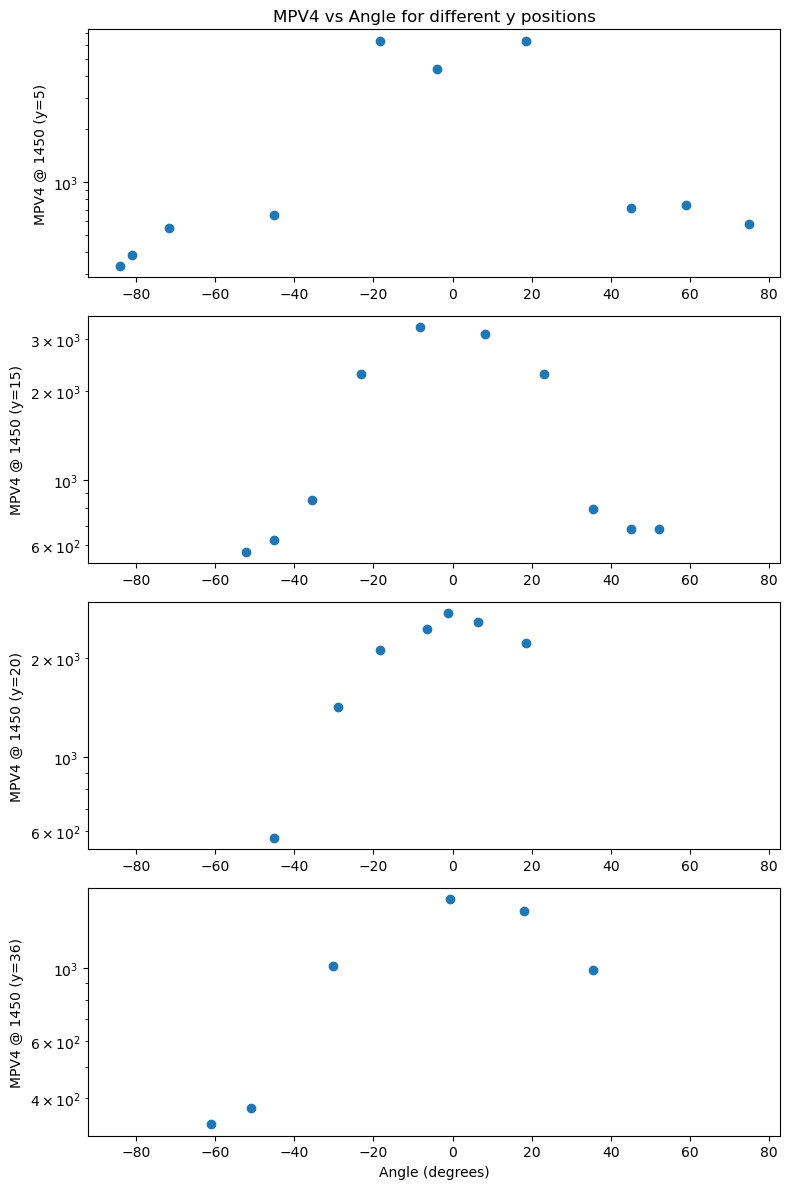

In [ ]:
mask = (ys == 5)
xs_5 = xs[mask]
ys_5 = ys[mask]
MPV4_at_1450_5 = MPV4_at_1450[mask]

mask = (ys == 15)
xs_15 = xs[mask]
ys_15 = ys[mask]
MPV4_at_1450_15 = MPV4_at_1450[mask]

mask = (ys == 20)
xs_20 = xs[mask]
ys_20 = ys[mask]
MPV4_at_1450_20 = MPV4_at_1450[mask]

mask = (ys == 36)
xs_36 = xs[mask]
ys_36 = ys[mask]
MPV4_at_1450_36 = MPV4_at_1450[mask]


angles_5 = np.arctan(((xs_5+2.5)-30)/(0-(5+2.5)))*180/np.pi
angles_15 = np.arctan(((xs_15+2.5)-30)/(0-(15+2.5)))*180/np.pi
angles_20 = np.arctan(((xs_20+2.5)-30)/(0-(20+2.5)))*180/np.pi
angles_36_2 = np.arctan(((xs_36+2.5)-30)/(0-(36+2.5)))*180/np.pi

fig, axs = plt.subplots(4, 1, figsize=(8, 12), sharex=True)

# Plot each row
axs[0].scatter(angles_5, MPV4_at_1450_5)
axs[0].set_ylabel('MPV4 @ 1450 (y=5)')
axs[0].set_title('MPV4 vs Angle for different y positions')
axs[0].set_yscale('log')
axs[0].tick_params(axis='x', labelbottom=True) 

axs[1].scatter(angles_15, MPV4_at_1450_15)
axs[1].set_ylabel('MPV4 @ 1450 (y=15)')
axs[1].set_yscale('log')
axs[1].tick_params(axis='x', labelbottom=True)

axs[2].scatter(angles_20, MPV4_at_1450_20)
axs[2].set_ylabel('MPV4 @ 1450 (y=20)')
axs[2].set_yscale('log')
axs[2].tick_params(axis='x', labelbottom=True)

axs[3].scatter(angles_36_2, MPV4_at_1450_36)
axs[3].set_ylabel('MPV4 @ 1450 (y=36)')
axs[3].set_xlabel('Angle (degrees)')
axs[3].set_yscale('log')
axs[3].tick_params(axis='x', labelbottom=True)

# Optional: adjust spacing
plt.tight_layout()
plt.show()

# Simulation Analysis

In [50]:
df_sim = pd.read_csv('anglescans/anglescans.csv')
print(df_sim)

    run      x     y  pmt1_hits  pmt2_hits
0    49   22.5  62.5        203         70
1    50   27.5  62.5        331         51
2    51   32.5  62.5        297         56
3    52   37.5  62.5        199         51
4    53   42.5  62.5          0         64
5    54   47.5  62.5          0         43
6    55   52.5  62.5          0         41
7    56   57.5  62.5          0         45
8    57   62.5  62.5          0         40
9    58   67.5  62.5          0         46
10   59   72.5  62.5          0         37
11   60   77.5  62.5          0         25
12   61   82.5  62.5          4          6
13   62   87.5  62.5          2          0
14   63   92.5  62.5          0          0
15   64   97.5  62.5          0          2
16   65  102.5  62.5          2          2
17   66  107.5  62.5          2          0
18   67    2.5  67.5          0         83
19   68    7.5  67.5          0         72
20   69   12.5  67.5          0         71
21   70   17.5  67.5          0         80
22   71   2

In [72]:
x, y, pmt1_hits, pmt2_hits = df_sim["x"].values, df_sim["y"].values, df_sim["pmt1_hits"].values, df_sim["pmt2_hits"].values

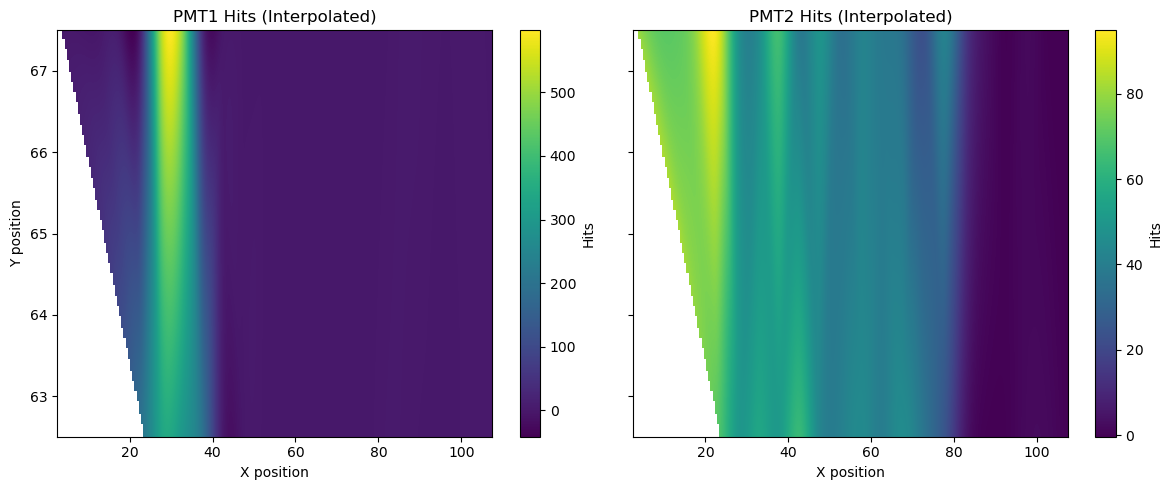

In [73]:
grid_x, grid_y = np.mgrid[x.min():x.max():200j, y.min():y.max():200j]

grid_pmt1 = griddata((x, y), pmt1_hits, (grid_x, grid_y), method='cubic')
grid_pmt2 = griddata((x, y), pmt2_hits, (grid_x, grid_y), method='cubic')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

p1 = ax1.imshow(grid_pmt1.T, extent=(x.min(), x.max(), y.min(), y.max()), origin='lower', cmap='viridis', aspect='auto', interpolation='bicubic')
ax1.set_title("PMT1 Hits (Interpolated)")
ax1.set_xlabel("X position")
ax1.set_ylabel("Y position")
fig.colorbar(p1, ax=ax1, label="Hits")

p2 = ax2.imshow(grid_pmt2.T, extent=(x.min(), x.max(), y.min(), y.max()), origin='lower', cmap='viridis', aspect='auto', interpolation='bicubic')
ax2.set_title("PMT2 Hits (Interpolated)")
ax2.set_xlabel("X position")
fig.colorbar(p2, ax=ax2, label="Hits")

plt.tight_layout()
plt.show()

C:\Users\Lukas\AppData\Local\Temp\ipykernel_17268\394917694.py:2: RuntimeWarning: divide by zero encountered in log10
  ax1.scatter(x,y,c=np.log10(pmt1_hits))
C:\Users\Lukas\AppData\Local\Temp\ipykernel_17268\394917694.py:3: RuntimeWarning: divide by zero encountered in log10
  ax2.scatter(x,y,c=np.log10(pmt2_hits))


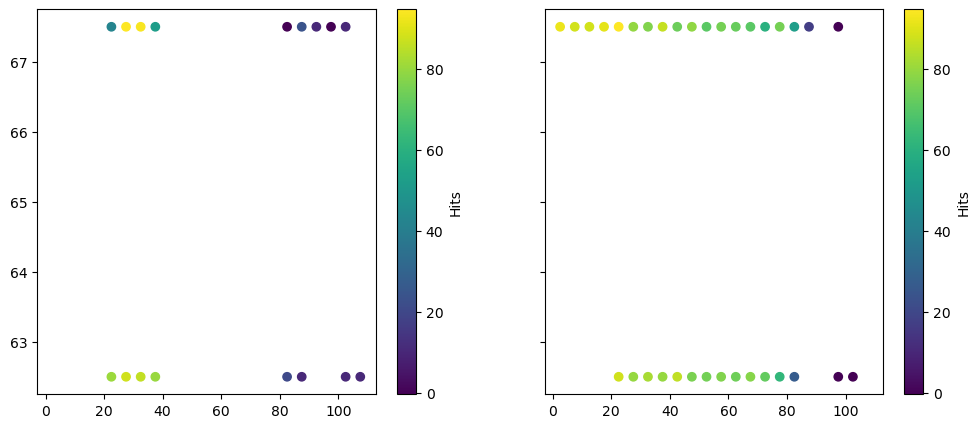

In [74]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,5),sharex=True,sharey=True)
ax1.scatter(x,y,c=np.log10(pmt1_hits))
ax2.scatter(x,y,c=np.log10(pmt2_hits))
fig.colorbar(p2, ax=ax1, label="Hits")
fig.colorbar(p2, ax=ax2, label="Hits")

In [75]:
pmt1 = (30, 76)
pmt2 = (30, 0)

def angler(x, y, ref):
    return np.degrees(np.arctan2(x - ref[0], np.abs(ref[1] - y)))

df_sim['angle_pmt1'] = angler(x,y, pmt1)
df_sim['angle_pmt2'] = angler(x,y,pmt2)

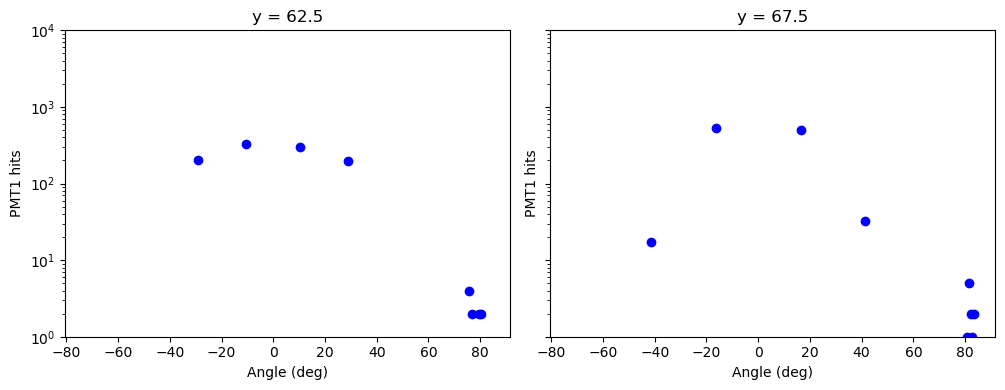

In [76]:

y_values = sorted(df_sim['y'].unique())

# Set up the plot: multiple subplots, one for each y-value
n_cols = 3  # adjust as you like
n_rows = int(np.ceil(len(y_values)/n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4), sharex=True, sharey=True)
axes = axes.flatten()

for i, y_val in enumerate(y_values):
    ax = axes[i]
    sub_df = df_sim[df_sim['y'] == y_val]
    ax.scatter(sub_df['angle_pmt1'], sub_df['pmt1_hits'], color='blue')
    ax.set_yscale('log')
    ax.set_ylim(1,10000)
    ax.set_title(f'y = {y_val}')
    ax.set_xlabel('Angle (deg)')
    ax.set_ylabel('PMT1 hits')

# Remove any empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

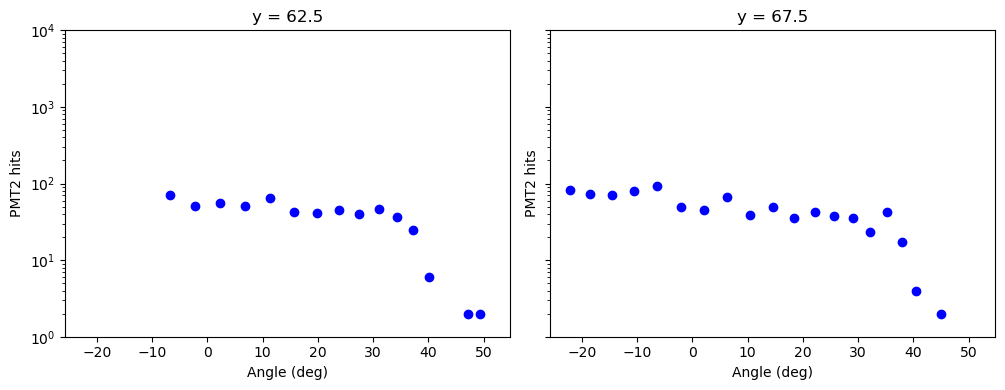

In [77]:

y_values = sorted(df_sim['y'].unique())

# Set up the plot: multiple subplots, one for each y-value
n_cols = 3  # adjust as you like
n_rows = int(np.ceil(len(y_values)/n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4), sharex=True, sharey=True)
axes = axes.flatten()

for i, y_val in enumerate(y_values):
    ax = axes[i]
    sub_df = df_sim[df_sim['y'] == y_val]
    ax.scatter(sub_df['angle_pmt2'], sub_df['pmt2_hits'], color='blue')
    ax.set_yscale('log')
    ax.set_ylim(1,10000)
    ax.set_title(f'y = {y_val}')
    ax.set_xlabel('Angle (deg)')
    ax.set_ylabel('PMT2 hits')

# Remove any empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [78]:
print(df_sim)

    run      x     y  pmt1_hits  pmt2_hits  angle_pmt1  angle_pmt2
0    49   22.5  62.5        203         70  -29.054604   -6.842773
1    50   27.5  62.5        331         51  -10.491477   -2.290610
2    51   32.5  62.5        297         56   10.491477    2.290610
3    52   37.5  62.5        199         51   29.054604    6.842773
4    53   42.5  62.5          0         64   42.797402   11.309932
5    54   47.5  62.5          0         43   52.352379   15.642246
6    55   52.5  62.5          0         41   59.036243   19.798876
7    56   57.5  62.5          0         45   63.853159   23.749494
8    57   62.5  62.5          0         40   67.442753   27.474432
9    58   67.5  62.5          0         46   70.201124   30.963757
10   59   72.5  62.5          0         37   72.377703   34.215702
11   60   77.5  62.5          0         25   74.134292   37.234834
12   61   82.5  62.5          4          6   75.579227   40.030259
13   62   87.5  62.5          2          0   76.787253   42.61

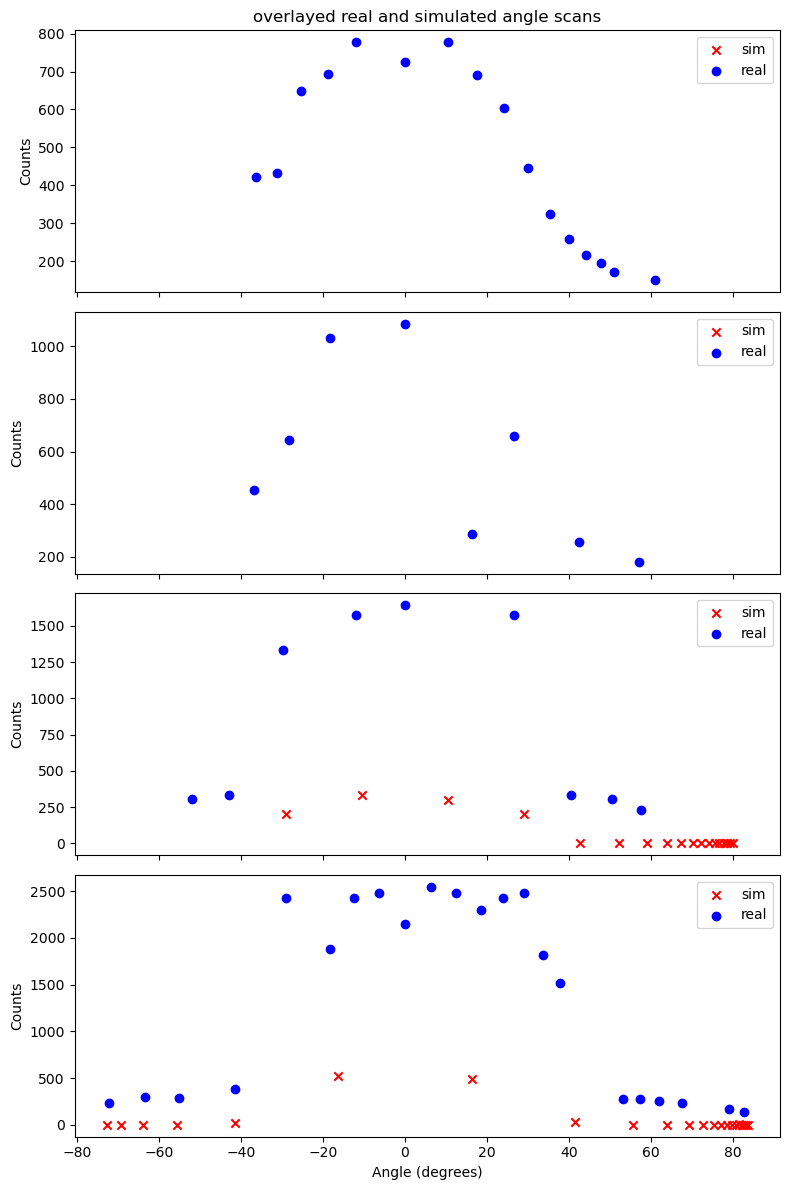

In [79]:
fig, axs = plt.subplots(4, 1, figsize=(8, 12), sharex=True)

df_y_values = [38.5, 52.5, 62.5, 67.5]
for i, y_val in enumerate(df_y_values):
    ax = axs[i]
    sub_df = df_sim[df_sim['y'] == y_val]
    ax.scatter(sub_df['angle_pmt1'], sub_df['pmt1_hits'],color='red', marker = 'x', label=f'sim')

for i, (angles, vals, y_val) in enumerate([(angles_36, MPV3_at_1450_36, 36),(angles_50, MPV3_at_1450_50, 50),(angles_60, MPV3_at_1450_60, 60),(angles_65, MPV3_at_1450_65, 65),]):
    ax = axs[i]
    ax.scatter(angles, vals,color='blue', label=f'real')

for ax in axs:
    #ax.set_yscale('log')
    ax.set_ylabel("Counts")
    ax.legend()

axs[0].set_title("overlayed real and simulated angle scans")
axs[-1].set_xlabel("Angle (degrees)")
plt.tight_layout()
plt.show()

In [62]:
print(len(angles_36))
print(len(angles_50))
print(len(angles_60))
print(len(angles_65))
print(len(MPV3_at_1450_36))

6
8
9
22
16
